In [492]:
# Goals
# X Fly over the paper again to get a feelling or it again
# X Transform my input into their input
# Create code for their implementation
    # Fingerprint creation
    # Detection
# Final: I want to be able to put in any series into the model, and the output is one of the X classes or "unknown"

# Implementing "Traffic-Based Side-Channel Attack in Video Streaming" 

Implementing [this](https://doi.org/10.1109/TNET.2019.2906568) paper. 

todo:: more notes on this notebook bro. 

## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.barycenters import dtw_barycenter_averaging
import logging
from sklearn.metrics import f1_score, precision_score, recall_score
from Utils import *
import scipy.stats as stats

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
blue = "#1f77b3"

In [4]:
# Create a logger
log_filename = 'log_file.log'
logger = logging.getLogger('my_logger')
logger.setLevel(logging.DEBUG)
# Create a file handler and set the level to DEBUG
file_handler = logging.FileHandler(log_filename)
file_handler.setLevel(logging.DEBUG)
# Create a formatter and add it to the handler
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
# Add the handler to the logger
logger.addHandler(file_handler)

In [5]:
def flush_log()->None:
    ! rm $log_filename
    ! touch $log_filename

In [6]:
data = pd.read_pickle("data/closed_world_mega_frame.pkl")

In [7]:
data.head()

,timestamp,data,video_id
0,"[2023-06-22 11:47:33.180000, 2023-06-22 11:47:...","[0.0, 0.0, 5861.0, 5861.0, 5890.0, 72784.0, 11...",3IosA_ir06Y
1,"[2023-06-22 10:59:57.390000, 2023-06-22 10:59:...","[5861.0, 5861.0, 5932.0, 72784.0, 25446.0, 567...",3IosA_ir06Y
2,"[2023-06-22 11:42:14.490000, 2023-06-22 11:42:...","[0.0, 5861.0, 5664.0, 5861.0, 72784.0, 11322.0...",3IosA_ir06Y
3,"[2023-06-22 12:14:02.060000, 2023-06-22 12:14:...","[0.0, 5861.0, 5861.0, 72784.0, 6067.0, 25446.0...",3IosA_ir06Y
4,"[2023-06-22 12:03:27.860000, 2023-06-22 12:03:...","[0.0, 5861.0, 5861.0, 7479.0, 7392.0, 26827.0,...",3IosA_ir06Y


## Preprocessing

In [13]:
data[["timestamp", "data"]] = data[["timestamp", "data"]].apply(lambda row: remove_leading_zeros(data=row["data"], timestamps=row["timestamp"]), axis=1, result_type = 'expand' )
data.head()

,timestamp,data,video_id
0,"[2023-06-22 11:47:43.490000, 2023-06-22 11:47:...","[5861.0, 5861.0, 5890.0, 72784.0, 11322.0, 254...",3IosA_ir06Y
1,"[2023-06-22 10:59:57.390000, 2023-06-22 10:59:...","[5861.0, 5861.0, 5932.0, 72784.0, 25446.0, 567...",3IosA_ir06Y
2,"[2023-06-22 11:42:25.130000, 2023-06-22 11:42:...","[5861.0, 5664.0, 5861.0, 72784.0, 11322.0, 254...",3IosA_ir06Y
3,"[2023-06-22 12:14:12.380000, 2023-06-22 12:14:...","[5861.0, 5861.0, 72784.0, 6067.0, 25446.0, 474...",3IosA_ir06Y
4,"[2023-06-22 12:03:38.540000, 2023-06-22 12:03:...","[5861.0, 5861.0, 7479.0, 7392.0, 26827.0, 5786...",3IosA_ir06Y


In [16]:
data["data"] = data["data"].apply(replace_zeros_with_ones)
data["DF"] = data["data"].apply(DF)
data.head()

,timestamp,data,video_id,DF
0,"[2023-06-22 11:47:43.490000, 2023-06-22 11:47:...","[5861.0, 5861.0, 5890.0, 72784.0, 11322.0, 254...",3IosA_ir06Y,"[0.0, 0.004947961098788603, 11.357215619694397..."
1,"[2023-06-22 10:59:57.390000, 2023-06-22 10:59:...","[5861.0, 5861.0, 5932.0, 72784.0, 25446.0, 567...",3IosA_ir06Y,"[0.0, 0.012113973724620372, 11.269723533378288..."
2,"[2023-06-22 11:42:25.130000, 2023-06-22 11:42:...","[5861.0, 5664.0, 5861.0, 72784.0, 11322.0, 254...",3IosA_ir06Y,"[-0.03361201160211568, 0.034781073446327686, 1..."
3,"[2023-06-22 12:14:12.380000, 2023-06-22 12:14:...","[5861.0, 5861.0, 72784.0, 6067.0, 25446.0, 474...",3IosA_ir06Y,"[0.0, 11.418358641869988, -0.9166437678610684,..."
4,"[2023-06-22 12:03:38.540000, 2023-06-22 12:03:...","[5861.0, 5861.0, 7479.0, 7392.0, 26827.0, 5786...",3IosA_ir06Y,"[0.0, 0.2760621054427572, -0.01163257119935820..."


## Traffic Aggregation

### Example

In [17]:
# example
example = data["data"][6]

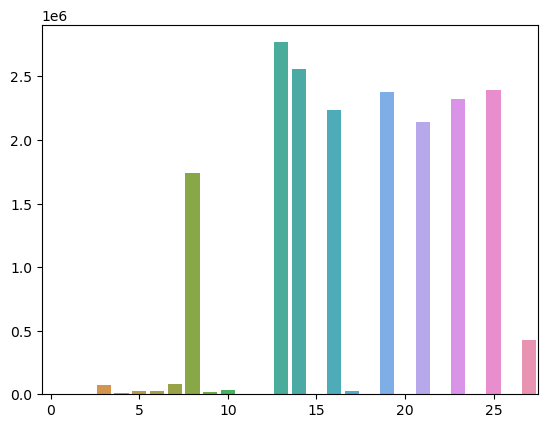

In [18]:
sns.barplot(y=example, x=list(range(len(example))))
plt.xticks(range(0, len(example), 5))
plt.show()

In [19]:
bps_colours=["#e996a3",
            "#e89686",
            "#e39361",
            "#c4994b",
            "#7aa946",
            "#7aa946",
            "#4aad95",
            "#4baba2",
            "#4faabd",
            "#7caee5"]

<AxesSubplot:>

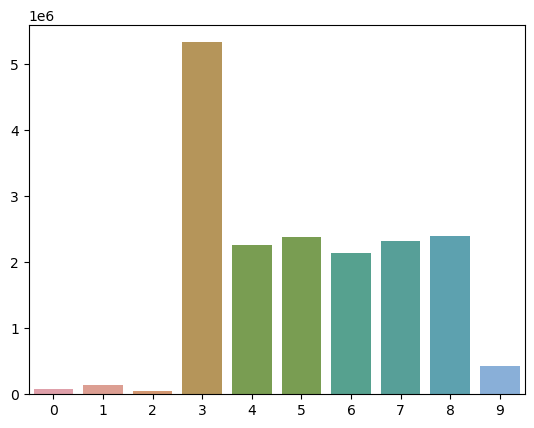

In [21]:
# Data amount threshold
e = 20000 #bytes Todo they do 20k bytes, I have 2k
# Maximum period length
t = 6/2 # L=6 seconds, t is L/2
data['bpp'] = data.data.map(lambda x: bin_per_period(x, e=e,t=t))
data.head()


aggregated_example = bin_per_period(example, e=e, t=t)
sns.barplot(y=aggregated_example, x=list(range(len(aggregated_example))),  palette=bps_colours)

In [22]:
aggregated_example

[72784.0,
 134096.0,
 54930.0,
 5326189.0,
 2257913.0,
 2374254.0,
 2139513.0,
 2323230.0,
 2393130.0,
 429516.0]

<AxesSubplot:>

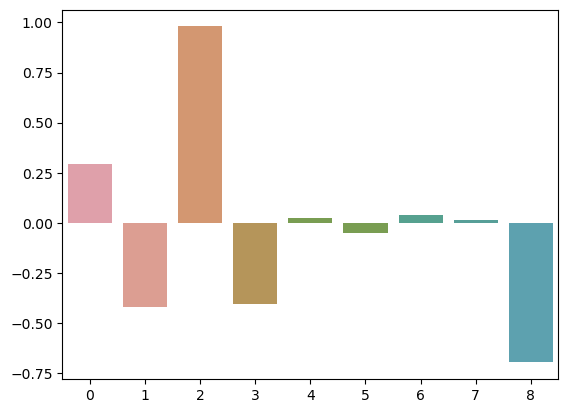

In [24]:
aggregated_example_df = DF_alt(aggregated_example)
sns.barplot(y=aggregated_example_df, x=list(range(len(aggregated_example_df))), palette=bps_colours)

In [25]:
aggregated_example_df

[0.2963650425367363,
 -0.41881011077841146,
 0.9795841719909929,
 -0.4045668162163431,
 0.02511589068356128,
 -0.0520055643102535,
 0.04116683394047114,
 0.014820751596570236,
 -0.6956642809619059]

### Aggregate

In [27]:
data['BPP'] = data.data.map(lambda x: bin_per_period(x, e=e,t=t))
data.head()

,timestamp,data,video_id,DF,bpp,BPP
0,"[2023-06-22 11:47:43.490000, 2023-06-22 11:47:...","[5861.0, 5861.0, 5890.0, 72784.0, 11322.0, 254...",3IosA_ir06Y,"[0.0, 0.004947961098788603, 11.357215619694397...","[72784.0, 25446.0, 1769820.0, 136981.0, 255710...","[72784.0, 25446.0, 1769820.0, 136981.0, 255710..."
1,"[2023-06-22 10:59:57.390000, 2023-06-22 10:59:...","[5861.0, 5861.0, 5932.0, 72784.0, 25446.0, 567...",3IosA_ir06Y,"[0.0, 0.012113973724620372, 11.269723533378288...","[98230.0, 1804708.0, 2897628.0, 4632168.0, 213...","[98230.0, 1804708.0, 2897628.0, 4632168.0, 213..."
2,"[2023-06-22 11:42:25.130000, 2023-06-22 11:42:...","[5861.0, 5664.0, 5861.0, 72784.0, 11322.0, 254...",3IosA_ir06Y,"[-0.03361201160211568, 0.034781073446327686, 1...","[72784.0, 134119.0, 1798127.0, 5354138.0, 4632...","[72784.0, 134119.0, 1798127.0, 5354138.0, 4632..."
3,"[2023-06-22 12:14:12.380000, 2023-06-22 12:14:...","[5861.0, 5861.0, 72784.0, 6067.0, 25446.0, 474...",3IosA_ir06Y,"[0.0, 11.418358641869988, -0.9166437678610684,...","[72784.0, 25446.0, 1777924.0, 130658.0, 255710...","[72784.0, 25446.0, 1777924.0, 130658.0, 255710..."
4,"[2023-06-22 12:03:38.540000, 2023-06-22 12:03:...","[5861.0, 5861.0, 7479.0, 7392.0, 26827.0, 5786...",3IosA_ir06Y,"[0.0, 0.2760621054427572, -0.01163257119935820...","[26827.0, 80651.0, 1743232.0, 81685.0, 5353928...","[26827.0, 80651.0, 1743232.0, 81685.0, 5353928..."


## Differential Fingerprint

In [28]:
data['DF'] = data.BPP.map(lambda x: DF(x))
data['DF_alt'] = data.BPP.map(lambda x: DF_alt(x))
#data['DTP'] = data.cropped_binned_sizes.apply(lambda vals: [1 if x == 0 else x for x in vals]).map(lambda x: DF_alt(x))
data.head(2)

,timestamp,data,video_id,DF,bpp,BPP,DF_alt
0,"[2023-06-22 11:47:43.490000, 2023-06-22 11:47:...","[5861.0, 5861.0, 5890.0, 72784.0, 11322.0, 254...",3IosA_ir06Y,"[-0.6503901956473951, 68.55199245460976, -0.92...","[72784.0, 25446.0, 1769820.0, 136981.0, 255710...","[72784.0, 25446.0, 1769820.0, 136981.0, 255710...","[-0.4819098035223455, 0.9716521117204916, -0.8..."
1,"[2023-06-22 10:59:57.390000, 2023-06-22 10:59:...","[5861.0, 5861.0, 5932.0, 72784.0, 25446.0, 567...",3IosA_ir06Y,"[17.372269164206454, 0.6055938135144301, 0.598...","[98230.0, 1804708.0, 2897628.0, 4632168.0, 213...","[98230.0, 1804708.0, 2897628.0, 4632168.0, 213...","[0.8967596421953842, 0.23242065220350056, 0.23..."


## Fingerprint detection

### Plan
- Get the sequence with the most amount variation --> into the fp database
- Get an average of the 5 most variation videos --> into fp database
- See which method is gives the best accuracy

### Get the sequence with the most amount variation → into the fp database

In [29]:
# Calculate varianve in the bpp
data["DF_var"] = data["DF"].map(np.var)
data["DF_var"].loc[data["DF_var"].isna()] = 0
data["DF_var"]

/Users/deborahdjon/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0        564.456283
1         41.512294
2         18.519396
3        575.262186
4        502.602832
           ...     
2495     176.497343
2496     129.424619
2497      73.157968
2498    2594.610793
2499     330.789658
Name: DF_var, Length: 2500, dtype: float64

In [30]:
print(np.var([120853]))
#BPP has always at least 1 value --> I Can replace the nans with Var = 0
print(sum(data["bpp"].map(len)==0))

0.0
0


In [34]:
# Get high varianve traces
video_ids = data["video_id"].unique()

# # Removint this video for now because it only no traces with more than 1 bpp measure
#video_ids = np.delete(video_ids, np.where(video_ids == "nonvpn_youtube_capture3.pcap"))

hig_var_traces = {}
for v_id in video_ids:
    DFs = data[["DF", "DF_var"]].loc[data["video_id"]==v_id]
    DFs = DFs.sort_values("DF_var", ascending=False)
    hig_var_traces[v_id]= DFs.head(5)

hig_var_traces 

{'3IosA_ir06Y':                                                    DF       DF_var
 7   [13.213282380499349, -0.9886440849570265, 262....  9426.472292
 20  [0.9192954495493515, 11.478925365441608, -0.98...  8359.917457
 27  [23.66566827874258, -0.9809331876167654, 155.8...  2892.319759
 35  [17.848050493739184, -0.9810094175141133, 151....  2755.830521
 24  [23.66566827874258, -0.9802608638497025, 149.8...  2684.179254,
 'bhpTZOqXRN0':                                                    DF       DF_var
 85  [-0.16298508276746027, -0.6715321332573104, 14...  5010.676089
 58  [-0.1608034034197824, -0.6723860589812333, 148...  4900.803196
 54  [-0.9338625293162547, 140.9581907454248, -0.97...  3417.001840
 69          [-0.8849063161011023, 104.05737185461324]  2753.220437
 53  [0.3233845209953624, -0.5249256865472197, -0.2...  2337.910679,
 'agTMr9qITlI':                                                     DF       DF_var
 114  [-0.8121579682408318, 22.61531577425617, -0.98...  9643.971798

In [36]:
data[["DF", "DF_var"]].sort_values("DF_var", ascending=False).to_csv("data_df")

In [37]:
#  Get differential FP of the top variance trace for each video
fp_db_top1_var =  {video_id: frame["DF"].head(1) for video_id, frame in hig_var_traces.items()}
fp_db_top1_var

{'3IosA_ir06Y': 7    [13.213282380499349, -0.9886440849570265, 262....
 Name: DF, dtype: object,
 'bhpTZOqXRN0': 85    [-0.16298508276746027, -0.6715321332573104, 14...
 Name: DF, dtype: object,
 'agTMr9qITlI': 114    [-0.8121579682408318, 22.61531577425617, -0.98...
 Name: DF, dtype: object,
 'sFEYQMrWNHU': 184    [2.0809759450171823, -0.9100432317157503, 197....
 Name: DF, dtype: object,
 'KUXS5fJPFSA': 203    [-0.8863212584543929, 111.28339235787512]
 Name: DF, dtype: object,
 'BuwLLUzp7DI': 271    [-0.9243542366204581, 138.5767990874374, 1.385...
 Name: DF, dtype: object,
 'xYcHxF_cO8o': 302    [1.250565102957114, 0.6480283976775543, 0.2997...
 Name: DF, dtype: object,
 'ZI9Fjo8k618': 384    [-0.9370291860626163, 181.5314072693383, -0.49...
 Name: DF, dtype: object,
 'beHTyPTJzlQ': 406    [-0.8741377713642484, -0.9303482415202274, 161...
 Name: DF, dtype: object,
 'JZ1ZoR0Y4SU': 497    [0.3644438352409019, -0.7971630350702711, 466....
 Name: DF, dtype: object,
 'WAfJpyBgcgA': 525  

In [39]:
fp_db_top1_var = {
    k: v.to_list() for k,v in fp_db_top1_var.items()
}
fp_db_top1_var

{'3IosA_ir06Y': [[13.213282380499349,
   -0.9886440849570265,
   262.50269948982117,
   -0.12926834861695505,
   0.4800573899861555,
   -0.9373506481231493]],
 'bhpTZOqXRN0': [[-0.16298508276746027,
   -0.6715321332573104,
   149.7421514655557]],
 'agTMr9qITlI': [[-0.8121579682408318,
   22.61531577425617,
   -0.988249794193577,
   266.36533690582513,
   -0.5335280944666967,
   -0.9791404672627632]],
 'sFEYQMrWNHU': [[2.0809759450171823,
   -0.9100432317157503,
   197.69637454743838,
   -0.599335549002013,
   -0.35037204364846986,
   0.6557301431277122,
   -0.9081604166449471]],
 'KUXS5fJPFSA': [[-0.8863212584543929, 111.28339235787512]],
 'BuwLLUzp7DI': [[-0.9243542366204581, 138.5767990874374, 1.3850826159521044]],
 'xYcHxF_cO8o': [[1.250565102957114,
   0.6480283976775543,
   0.2997194904075738,
   -0.8443118388006398,
   312.73463157026157,
   0.37382678221532556]],
 'ZI9Fjo8k618': [[-0.9370291860626163,
   181.5314072693383,
   -0.4923716481786127,
   0.16257301189191625,
   -0.14

In [40]:
def average_sequences(X):
    return dtw_barycenter_averaging(X, max_iter=50, tol=1e-3)

In [42]:
# Get differential FP of the top 5 varianve traces for each video
fp_db_top5_var = {video_id: average_sequences(list(frame["DF"])) for video_id, frame in hig_var_traces.items()}
fp_db_top5_var 

{'3IosA_ir06Y': array([[ 1.51318150e+01],
        [-9.83853237e-01],
        [ 1.96568507e+02],
        [-3.10470928e-01],
        [-1.32262424e-01],
        [ 1.09558049e+00],
        [-4.57873589e-01]]),
 'bhpTZOqXRN0': array([[ -0.36383456],
        [ -0.65294775],
        [130.87260039],
        [ 90.13794683]]),
 'agTMr9qITlI': array([[-3.72951760e-02],
        [-7.59483861e-01],
        [ 6.10560651e+00],
        [ 1.60386732e+02],
        [-4.46657193e-01],
        [-9.79140467e-01]]),
 'sFEYQMrWNHU': array([[  1.13150836],
        [ -0.78420135],
        [129.4014613 ],
        [ -0.72433683],
        [ -0.623836  ],
        [  0.83027608],
        [  0.21794083]]),
 'KUXS5fJPFSA': array([[14.72262444],
        [98.27302709],
        [80.38414602]]),
 'BuwLLUzp7DI': array([[ -0.7571639 ],
        [112.63278759],
        [  1.34631698]]),
 'xYcHxF_cO8o': array([[-1.70145089e-01],
        [ 1.85154483e+02],
        [ 1.61036186e-01],
        [ 1.61036186e-01],
        [ 8.2442037

In [43]:
# Take out the IDs of the fingerprints remove them from the database
hig_var_traces_ids =  {video_id: list(frame["DF"].index) for video_id, frame in hig_var_traces.items()}
hig_var_traces_ids
exclude_1 = np.array([x[0] for x in hig_var_traces_ids.values()])
exclude_5 = np.ndarray.flatten(np.array(list(hig_var_traces_ids.values()))) 

print(exclude_1)
print(exclude_5)

data_1 = data.drop(exclude_1)
data_1 = data_1[data_1.DF.map(len)>0]
data_5 = data.drop(exclude_5)
data_5 = data_5[data_5.DF.map(len)>0]


[   7   85  114  184  203  271  302  384  406  497  525  583  613  654
  708  764  823  885  944  968 1000 1059 1142 1197 1244 1290 1308 1385
 1430 1492 1507 1590 1643 1684 1731 1792 1805 1866 1918 1953 2036 2060
 2122 2195 2231 2286 2331 2389 2414 2470]
[   7   20   27   35   24   85   58   54   69   53  114  106  127  134
  109  184  175  152  154  167  203  234  225  245  242  271  298  260
  279  289  302  300  308  330  325  384  352  395  364  356  406  427
  421  426  424  497  488  481  492  455  525  536  533  505  542  583
  584  575  568  596  613  639  614  619  631  654  689  667  673  668
  708  717  748  730  707  764  796  777  773  794  823  816  848  825
  843  885  875  874  870  877  944  915  921  945  910  968  982  952
  983  985 1000 1016 1006 1027 1003 1059 1099 1070 1085 1095 1142 1143
 1146 1133 1127 1197 1174 1164 1183 1185 1244 1247 1231 1235 1234 1290
 1274 1294 1289 1277 1308 1333 1324 1315 1300 1385 1376 1354 1358 1377
 1430 1437 1416 1419 1414 1492 1476

In [46]:
X_test_1 = data_1['DF']
Y_test_1 = data_1['video_id']

X_test_5 = data_5['DF']
Y_test_5 = data_5['video_id']

In [47]:
# TODO:: improve on these thresholds
thresholds = [i/10 for i in range(1, 20)]

# Use min-max scaling to define the first value, and have that as a fingerprint 
# just try predicting with what I have now

In [524]:
#X_test_1.append(data.iloc[exclude_1]['bpp'])

In [48]:
threshold = 100000 #thresholds[-1]
Y_hat1 = [match(fp_db_top1_var, x, threshold)[0] for x in X_test_1]

In [49]:
performance_1 = [x==y for x,y in zip(Y_test_1,Y_hat1)]
print("Accuracy: ", sum(performance_1)/len(Y_test_1))

Accuracy:  0.04163265306122449


In [50]:
Y_hat5 = [match(fp_db_top5_var, x, threshold)[0] for x in X_test_5]
performance_5 = [x==y for x,y in zip(Y_test_5,Y_hat5)]
print("Accuracy: ", sum(performance_5)/len(Y_test_5))

Accuracy:  0.03333333333333333


In [528]:
#Mcnemar test
ctab = [[x,y] for x,y in zip(performance_1, performance_5)]
t1f5 = sum([1 for xy in ctab if xy[0]==1 and xy[1]==0])
t5f1 = sum([1 for xy in ctab if xy[0]==0 and xy[1]==1])

chi2 = ((t1f5-t5f1)**2)/(t1f5+t5f1)
df = 1

chi2

# p-value for df1 and alpha 0.05 is 3.841. The model 2 is not significatly better

8.0